<a href="https://colab.research.google.com/github/MKDMK/ML/blob/main/active.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drift detection for classification


In [336]:
!pip install -U stream-learn scikit-multiflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [337]:
import sklearn
import strlearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skmultiflow
import sklearn
sns.set_style()

In [338]:
from strlearn.streams import StreamGenerator
from strlearn.evaluators import TestThenTrain # evaluator
from sklearn.naive_bayes import GaussianNB # detector model
from sklearn.linear_model import Perceptron # classifier
from skmultiflow.drift_detection import DDM, EDDM, KSWIN # detector
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from strlearn.metrics import precision, recall

# Stream helpers

In [339]:
RSTATE = 199234

def stream2numpy(stream):
  ls_features = []
  ls_lbls = []
  while not stream.is_dry():
    feat, lbls = stream.get_chunk()
    ls_features.append(feat)
    ls_lbls.append(lbls)
  return np.array(ls_features), np.array(ls_lbls)

#sudden drift
def get_stream(drifts=3, concept_sigmoid_spacing=100.0, rstate=RSTATE, increm=False):
  return StreamGenerator(
    n_chunks=1000,
    chunk_size=200,
    random_state=rstate,
    n_drifts=drifts,
    concept_sigmoid_spacing=concept_sigmoid_spacing,
    n_classes=3,
    n_features=20,
    #n_redundant=2,
    #n_repeated=0,
    #n_clusters_per_class=2,
    #recurring=False,
    #weights=(1.0, 0.5),
    incremental=increm,
    #y_flip=0.02,
    n_informative=3)

def get_numpy_stream(drifts=3, concept_sigmoid_spacing=100.0, rstate=RSTATE, increm=False):
  stream = get_stream(drifts, concept_sigmoid_spacing, rstate, increm)
  return stream2numpy(stream)

def plot_score(evaluator, metrics, figsize=(12,6)):
  plt.figure(figsize=figsize)
  for i in range(0, len(metrics)):
    score = (metrics[i].__name__, evaluator.scores[0, :, i])
    plt.plot(score[1], label=score[0], ls='-', marker='o')
  plt.legend()
  plt.grid()
  return plt

# Drift detector definition
## helpers

In [340]:
def split(features, labels, rstate=None):
  return KFold(n_splits=2, shuffle=True, random_state=rstate).split(features, labels)

In [341]:
class CustomDriftDetector(skmultiflow.drift_detection.base_drift_detector.BaseDriftDetector):
  def __init__(self, warn_t=0.4, drift_t=0.25):
    super().__init__()
    self.warning_threshold = warn_t
    self.drift_threshold = drift_t
    # accuracy_score, precision_score, recall_score
    self.metric = accuracy_score
    self.reset()

  def reset(self):
    super().reset()

  def add_element(self, pred):
    if self.in_concept_change:
      self.reset()

    self._score = self._eval(pred)

    self.estimation = self._score
    self.in_concept_change = False
    self.in_warning_zone = False

    if self.estimation > self.warning_threshold:
      self.in_warning_zone = True
    if self.estimation > self.drift_threshold:
      self.in_concept_change = True

  def _eval(self, pred_hit):
    y_true = np.ones(1)
    y_pred = [pred_hit]
    return self.metric(y_true, y_pred)

In [342]:
from sklearn.base import ClassifierMixin, clone
from sklearn.ensemble import BaseEnsemble

In [343]:
class DetectionSupportedEstimator(BaseEnsemble, ClassifierMixin):
  def __init__(self, detector, dctor_mdl_provider, history_len=30):
    self._nofchunks = 0
    self._drifts = []
    self.last_n_chunks = history_len
    self._detector_mdl_provider = dctor_mdl_provider
    self.detector_model = self._detector_mdl_provider()
    self.detector = detector
    self.reset()

  def reset(self):
    self._history = []
    self._is_recording = False

  def start_recording(self):
    self.reset()
    self._is_recording = True

  def stop_recording(self):
    self._is_recording = False

  def process(self, stream:tuple):
    features, labels = stream

    for i in range(0,len(features)):
      self._nofchunks += 1
      chunk = features[i]
      chunk_lbl = labels[i]

      if i > 0:
        y_pred = self.detector_model.predict(chunk)
        
        for hit in (y_pred == chunk_lbl):
          self.detector.add_element(int(hit))

          if self.detector.detected_change():
            self._drifts.append(self._nofchunks)
            hist_arr = np.array(self._history)
            hist_lbl_arr = np.array(self._history_lbl)

            if self._last_detector_model:
              # check if last model is working (recurrent stream)
              pass

            # keep old model for recurrent streams handling
            self._last_detector_model = self.detector_model
            self.detector_model = self._detector_mdl_provider()
            self.detector_model.partial_fit(
                hist_arr.reshape(-1, *hist_arr.shape[2:]),
                hist_lbl_arr.reshape(-1, *hist_lbl_arr.shape[2:]))
            
          elif self.detector.detected_warning_zone():
            self.start_recording()
          else:
            self.stop_recording()

        if self._is_recording:
          self._history.append(chunk)
          self._history_lbl.append(chunk_lbl)

      self.detector_model.partial_fit(chunk, chunk_lbl, classes=(3,))

# Sudden concept drifts

In [344]:
TEST_MODEL = Perceptron
TEST_D_MODEL = GaussianNB
TEST_DETECTORS = [DDM, EDDM, KSWIN]
TEST_METRICS = [accuracy_score, precision, recall]
#number of examples until a change is detected -> drift_detected - drift_start
#false alarm rates -> detected_change/n_of_changes
#miss detections rates -> drift without detected_change

In [345]:
stream = get_stream()

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

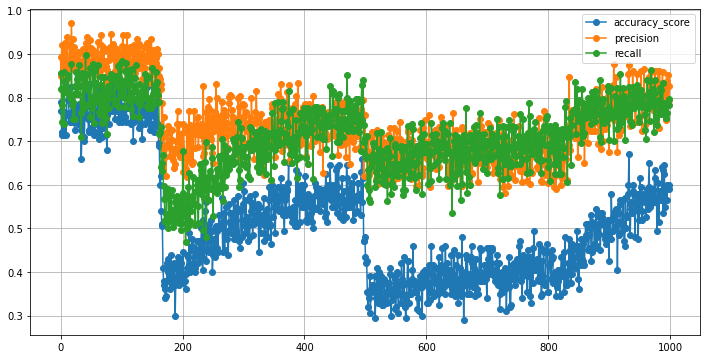

In [346]:
evaluator = TestThenTrain(TEST_METRICS)
evaluator.process(stream, TEST_D_MODEL())
plot_score(evaluator, TEST_METRICS)

### DDM

In [347]:
def run_ddm():
  DETECTOR = DDM(min_num_instances=60)
  model = TEST_D_MODEL()
  warnings = set()
  drifts = set()
  for chunk_id in range(str_data.shape[0]):
    if chunk_id == 0:
      model.partial_fit(str_data[chunk_id], str_labels[chunk_id], classes=[0,1,2])
    lbls = model.predict(str_data[chunk_id])
    for pred, true in zip(lbls, str_labels[chunk_id]):
      elem = 1 if pred == true else 0
      DETECTOR.add_element(elem)
      if DETECTOR.detected_warning_zone():
        warnings.add(chunk_id)
      if DETECTOR.detected_change():
        drifts.add(chunk_id)
        model = TEST_D_MODEL()
        model.partial_fit(str_data[chunk_id], str_labels[chunk_id], classes=[0,1,2])
    if chunk_id > 0:
      model.partial_fit(str_data[chunk_id], str_labels[chunk_id])
  return warnings, drifts

In [348]:
str_data, str_labels = get_numpy_stream()

In [349]:
def plot_detectors(warnings, drifts):
  plt = plot_score(evaluator, TEST_METRICS)
  for w in warnings:
    plt.axvline(x=w, color='yellow')
  for d in drifts:
    plt.axvline(x=d, color='red')
  plt.xlabel('chunks')
  plt.ylabel('score')
  plt

In [350]:
warnings, drifts = run_ddm()
print(warnings)
print(drifts)

{6, 7, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 734, 735, 739, 740, 741, 742, 744, 745, 746, 747, 748, 749, 750, 751, 756, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 801, 803, 804, 805, 806, 807, 808, 809, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 392, 393, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446}
{841, 843, 751, 114, 788, 730, 443, 735}


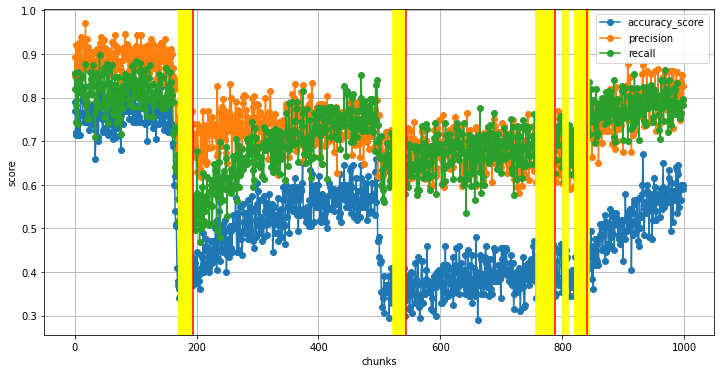

In [351]:
warnings = {193, 192, 191, 190, 189, 188, 187, 186, 185, 184, 183, 182, 181, 180, 179, 178, 177, 176, 175, 174, 173, 172, 171, 756, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 801, 803, 804, 805, 806, 807, 808, 809, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 542, 541, 540, 539, 538, 537, 536, 535, 534, 533, 532, 531, 530, 529, 528, 527, 526, 525, 524, 523, 522}
drifts = {841, 194, 788, 543}
plot_detectors(warnings, drifts)

### EDDM

In [352]:
def run_eddm():
  DETECTOR = EDDM()
  model = TEST_D_MODEL()
  warnings = set()
  drifts = set()
  for chunk_id in range(str_data.shape[0]):
    if chunk_id == 0:
      model.partial_fit(str_data[chunk_id], str_labels[chunk_id], classes=[0,1,2])
    lbls = model.predict(str_data[chunk_id])
    for pred, true in zip(lbls, str_labels[chunk_id]):
      elem = 1 if pred == true else 0
      DETECTOR.add_element(elem)
      if DETECTOR.detected_warning_zone():
        warnings.add(chunk_id)
      if DETECTOR.detected_change():
        drifts.add(chunk_id)
        model = TEST_D_MODEL()
        model.partial_fit(str_data[chunk_id], str_labels[chunk_id], classes=[0,1,2])
    if chunk_id > 0:
      model.partial_fit(str_data[chunk_id], str_labels[chunk_id])
  return warnings, drifts

{0, 1, 3, 6, 7, 8, 9, 13, 14, 15, 16}
{0, 1}


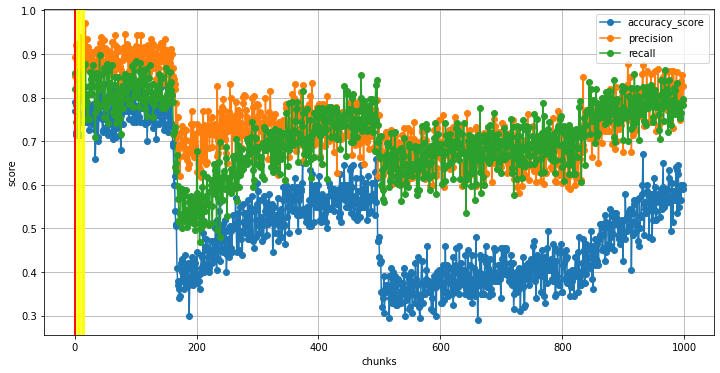

In [353]:
warnings, drifts = run_eddm()
print(warnings)
print(drifts)
plot_detectors(warnings, drifts)

### Komolgorov-Smirnoff algorithm

In [354]:
def run_ks():
  DETECTOR = KSWIN(alpha=0.01)
  warnings = set()
  drifts = set()
  for chunk_id in range(str_data.shape[0]):
    for entry in [0]:#range(len(str_data[chunk_id])):
      DETECTOR.add_element(str_data[chunk_id][entry][0])
      if DETECTOR.detected_change():
        drifts.add(chunk_id)
  return warnings, drifts

set()
{209, 355, 813, 102}


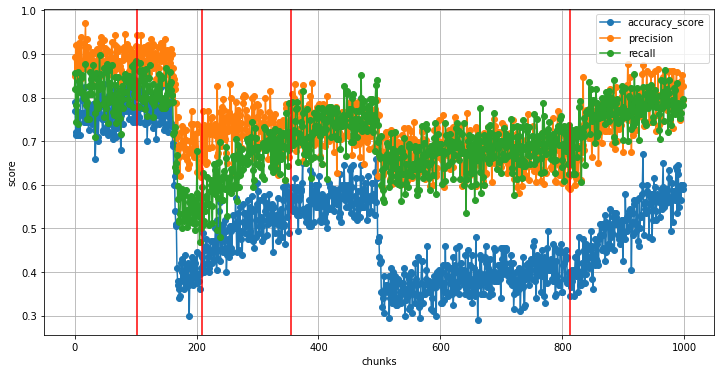

In [355]:
warnings, drifts = run_ks()
print(warnings)
print(drifts)
plot_detectors(warnings, drifts)

## Gradual concept drifts

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

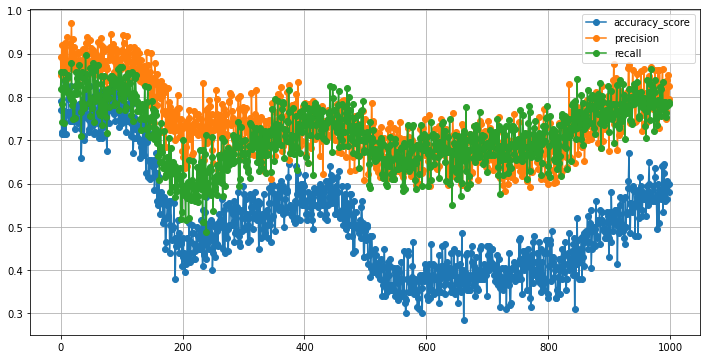

In [356]:
stream_gradual = get_stream(3, 10.0, RSTATE, False)
evaluator = TestThenTrain(TEST_METRICS)
evaluator.process(stream_gradual, TEST_D_MODEL())
plot_score(evaluator, TEST_METRICS)

In [357]:
str_data, str_labels = get_numpy_stream(3, 10.0, RSTATE, False)

### DDM

{6, 7, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999}
{968}


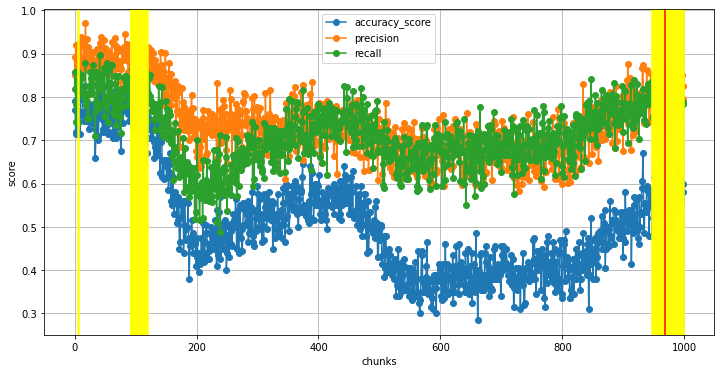

In [358]:
warnings, drifts = run_ddm()
print(warnings)
print(drifts)
plot_detectors(warnings, drifts)

### EDDM

{0, 1, 3, 6, 7, 8, 9, 13, 14, 15, 16}
{0, 1}


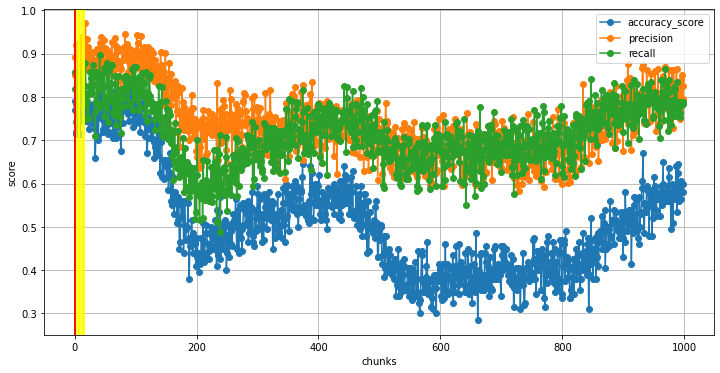

In [359]:
warnings, drifts = run_eddm()
print(warnings)
print(drifts)
plot_detectors(warnings, drifts)

### Komolgorov-Smirnoff algorithm

set()
{355, 102, 813, 215, 922}


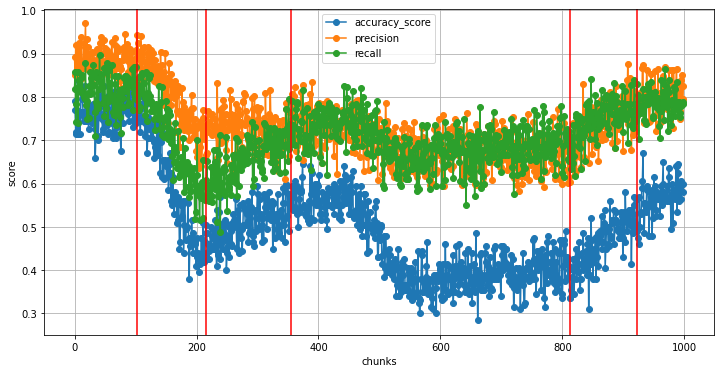

In [360]:
warnings, drifts = run_ks()
print(warnings)
print(drifts)
plot_detectors(warnings, drifts)

# Incremental concept drifts

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

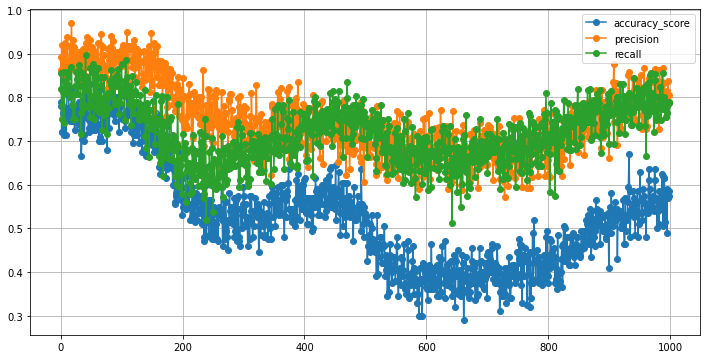

In [361]:
stream_incremental = get_stream(3, 5.0, RSTATE, True)
evaluator = TestThenTrain(TEST_METRICS)
evaluator.process(stream_incremental, TEST_D_MODEL())
plot_score(evaluator, TEST_METRICS)

In [362]:
str_data, str_labels = get_numpy_stream(3, 5.0, RSTATE, True)

### DDM

{992, 993, 6, 7, 994, 13, 14, 15, 16, 995, 19, 20, 21, 996, 997, 998, 999, 991, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 989, 990}
set()


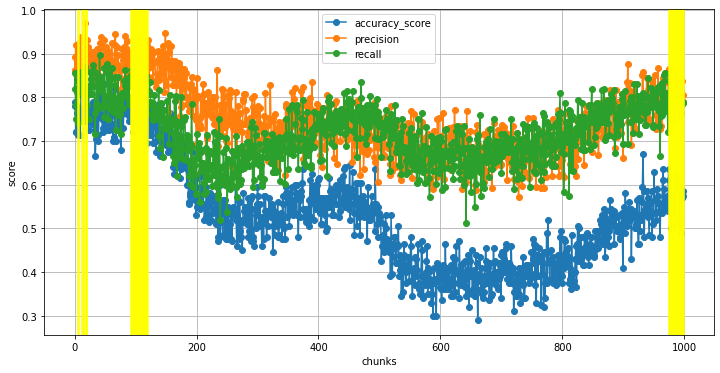

In [363]:
warnings, drifts = run_ddm()
print(warnings)
print(drifts)
plot_detectors(warnings, drifts)

### EDDM

{0, 1, 6, 7, 8, 9, 13, 14, 15, 16, 18, 19, 20, 21, 22}
{0, 1}


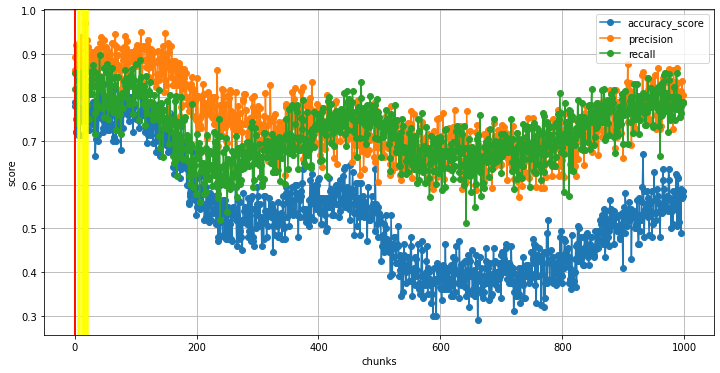

In [364]:
warnings, drifts = run_eddm()
print(warnings)
print(drifts)
plot_detectors(warnings, drifts)

### Komolgorov-Smirnoff algorithm

In [365]:
warnings, drifts = run_ks()
print(warnings)
print(drifts)


set()
{216, 810, 355, 102}


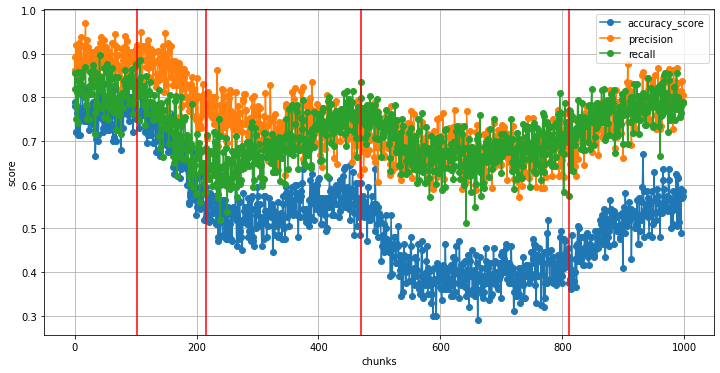

In [366]:
drifts = {216, 810, 470, 102}
plot_detectors(warnings, drifts)